# An Efficient Implementation of a Nanowire Network

This model has been modified for speed in order to run more simulations, faster. The idea is to keep this in Python and use AWS lambda to run thousands of instances in parallel.

## Imports

Because this will be run on Lambda, I'll keep the requirements list short---math and random are built in, and numpy is almost universally available. That will do for now.

In [2]:
import math; import random; import numpy as np; import pywren

## Topological Classes

Define nanowire, junction, and electrode classes to use while generating the network. These classes will store only the topology of the network and will not be used for computation, which will use vector math instead.

In [3]:
class Nanowire:
    def __init__(self, start=(0,0), end=(1,1)):
        self.start = start; self.end = end # tuples that store endpoint coordinates in µm
        self.min = (min(start[0], end[0]), min(start[1], end[1])) # for bounding box checks
        self.max = (max(start[0], end[0]), max(start[1], end[1])) # ~
        self.electrodes = []; self.junctions = [] # store indices of connected items

class Junction:
    def __init__(self, position=(0,0), start=0, end=0):
        self.position = position # tuple that stores coordinates in µm
        self.start = start; self.end = end # store nanowire indices

class Electrode:
    def __init__(self, x=0, y=0, width=0, height=0):
        self.x = x; self.y = y # store lower-left corner in µm
        self.width = width; self.height = height # size in µm

## Network Creation

These functions create electrode, nanowire, and junction arrays for later use, respectivly. The intended use is as follows: manually define several Electrode objects. Call create_electrodes with these objects as arguments for an array. Next, call create_nanowires, with the electrodes array as an argument, to obtain a list of nanowires. Additional arguments can determine the geometrical nanowire distribution. Finally, use the create_junctions function, called with the list of nanowires, to obtain a list of junctions between nanowires and append the proper indices to corresponding nanowires.

In [4]:
def create_electrodes(*electrodes):
    """Form an array of electrodes."""
    return electrodes
           
def create_nanowires(electrodes=[],
                     num_nanowires=100,
                     xmin=0, xmax=100, ymin=0, ymax=100,
                     lmin=20, lmax=40, seed=1):
    """Form an array of nanowires and compute electrode intersections.
    
    Keyword arguments:
    electrodes -- list of electrodes
    num_nanowires -- the number of nanowires to create in the array
    xmin, xmax, ymin, ymax -- the uniform range of nanowire centerpoints, in µm
    lmin, lmax -- the uniform range of nanowire lengths, in µm
    seed -- random number generator initialization constant
    """
    random.seed(seed)
    nanowires = []
    for index in range(num_nanowires):
        new_length = random.uniform(lmin, lmax)
        new_angle  = random.uniform(0, math.pi)
        new_x      = random.uniform(xmin, xmax)
        new_y      = random.uniform(ymin, ymax)
        new_dx     = math.cos(new_angle) * new_length / 2
        new_dy     = math.sin(new_angle) * new_length / 2
        new_start  = np.array((new_x - new_dx, new_y - new_dy))
        new_end    = np.array((new_x + new_dx, new_y + new_dy))
        new_nw     = Nanowire(new_start, new_end)
        for i, el in enumerate(electrodes):
            # check for rough intersection via bouding box
            if not (new_nw.min[0] < el.x + el.width and
                    new_nw.min[1] < el.y + el.height and
                    new_nw.max[0] > el.x and
                    new_nw.max[1] > el.y):
                continue
            # check for true intersection
            signs = []
            nw_delta = new_end - new_start
            for point in [(el.x, el.y), (el.x+el.width, el.y+el.height),
                          (el.x+el.width, el.y), (el.x, el.y+el.height)]:
                point_delta = np.array(point) - new_start
                signs.append(np.cross(nw_delta, point_delta))
            if any(x < 0 for x in signs) and any(x > 0 for x in signs):
                new_nw.electrodes.append(i)
        nanowires.append(new_nw)
    return nanowires

def create_junctions(nanowires=[], seed=1):
    """Form an array of junctions and compute nanowire intersections."""
    random.seed(seed)
    junctions = []
    junction_counter = 0
    for i, nwa in enumerate(nanowires):
        u = nwa.end - nwa.start
        up = np.array([-u[1], u[0]])
        for j, nwb in enumerate(nanowires):
            if j <= i:
                continue # avoid duplicates
            if not (nwa.min[0] < nwb.max[0] and
                    nwa.min[1] < nwb.max[1] and
                    nwa.max[0] > nwb.min[0] and
                    nwa.max[1] > nwb.min[1]):
                continue # avoid nanowires with non-intersecting bouding boxes
            v = nwb.end - nwb.start
            dot = np.dot(up, v)
            if dot == 0:
                continue # avoid parallel nanowires
            p = nwa.start - nwb.start
            t = np.dot(up, p) / dot
            if not 0 <= t <= 1:
                continue # intersection must be on nwb
            vp = np.array([-v[1], v[0]])
            s = np.dot(vp, p) / dot
            if not 0 <= s <= 1:
                continue # intersection must be on nwa
            if set(nwa.electrodes).intersection(nwb.electrodes):
                continue # avoid nanowires on same electrode
            flip = random.choice([True, False]) # in case of asymmetry
            new_junction = Junction(nwa.start+s*u, start=i if flip else j,
                                                   end=j if flip else i)
            nwa.junctions.append(junction_counter)
            nwb.junctions.append(junction_counter)
            junctions.append(new_junction)
            junction_counter += 1
    return junctions

## Simulation

Finally, run the thing.

Profiling shows about an 8x speedup. Approximately half of this is the use of a basic linear solve rather than a least squares fit, and the other half comes from miscellaneous optimizations.

/usr/lib/python3/dist-packages/ipykernel/__main__.py:106: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


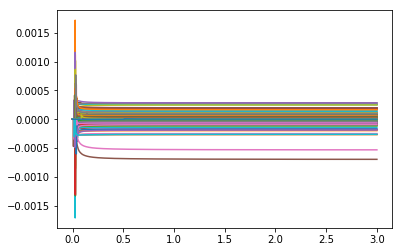

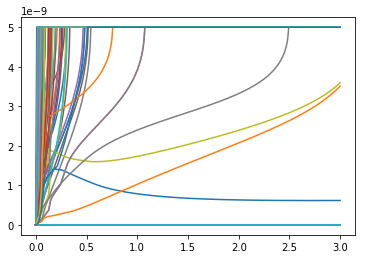

In [114]:
def simulate():
    """
    ron, roff -- the resistances of the junction in full on / off states, in Ω
    ron_sigma, roff_sigma -- their standard deviations, as fractions
    mwidth -- the total width of the junction, in m
    mw_sigma -- its standard deviation, as a fraction
    initial_width -- the initial width, as a fraction of max_width
    mobility -- the mobility of ions in the junction, in m^2/(s*V)
    dissolution_time -- the junction dissolution time constant, in s
    noise_sigma -- the noise of dwidth/dtime as a fraction of dwidth/dtime
    """
    
    np.random.seed(0)
    random.seed(0)
    
    ### define network topology ###
    
    e1, e2 = Electrode(0,0,20,20), Electrode(80,80,20,20)
    electrodes = create_electrodes(e1, e2)
    nanowires = create_nanowires(electrodes, num_nanowires=100)
    #nanowires = [Nanowire(np.array((0,0)),np.array((50, 100))), Nanowire(np.array((100,100)), np.array((0, 50)))]
    #nanowires[0].electrodes=[0]; nanowires[1].electrodes=[1]
    junctions = create_junctions(nanowires)
    #junctions[0].start = 0; junctions[0].end = 1
    n = len(nanowires); m = len(junctions); o = len(electrodes)
   
    ### define constants ###
    
    ron=5e3; ron_sigma=0; roff=5e6; roff_sigma=0
    mwidth=5e-9; mw_sigma=0; initial_width=0
    mobility=0.5e-12; dissolution_time=1
    noise_sigma=0
    rons = ron + np.random.randn((m)) * ron * ron_sigma
    roffs = roff + np.random.randn((m)) * roff * roff_sigma
    mwidths = mwidth + np.random.randn((m)) * mwidth * mw_sigma
   
    ### calculate adjacency matrices ###
    
    # for voltage calculations
    ne_adjacency = np.zeros((n, o))
    ne_presence = np.zeros((n, n))
    for i, nanowire in enumerate(nanowires):
        if not nanowire.electrodes:
            continue
        ne_adjacency[i, nanowire.electrodes[0]] = 1
        ne_presence[i, i] = 1
    node_adjacency = np.zeros((n, n))
    
    # for current calculations
    jn_adjacency = np.zeros((m, n))
    for i, junction in enumerate(junctions):
        jn_adjacency[i, junction.start] = -1
        jn_adjacency[i, junction.end] = 1
    
    # for resistance calculations
    conductivities_slope = (rons - roffs) / mwidths
    
    # for width calculations
    growth_slope = mobility * rons / mwidths
       
    # define state vectors
    voltages = np.zeros((n))
    currents = np.zeros((m))
    widths = mwidths*initial_width
    conductivities = 1. / (roffs + conductivities_slope * widths)
    
    current_time = 0 # s
    timestep = 0.001 # s
    total_time = 3 # s
    
    ts = []
    vs = []
    cs = []
    ws = []
    for i in range(m):
        cs.append([])
        ws.append([])
    
    while current_time < total_time:
        
        # define voltage inputs
        e_voltages = np.zeros((o))
        if current_time <= 0.5:
            e_voltages[1]= .01
        elif current_time <= 1:
            e_voltages[1]= 0
        elif current_time <= 1.5:
            e_voltages[1]= .01
        e_voltages[1]= 10
       
        for i, nanowire in enumerate(nanowires):
            if nanowire.electrodes:
                continue
            else:
                for j in nanowire.junctions:
                    conductance = conductivities[j]
                    othernanowire = junctions[j].start
                    if othernanowire == i:
                        othernanowire = junctions[j].end
                    node_adjacency[i][i] += conductance
                    node_adjacency[i][othernanowire] -= conductance
        
        A = ne_presence + node_adjacency
        B = np.dot(ne_adjacency, e_voltages)
        #voltages = np.linalg.solve(A, B)
        voltages = np.linalg.lstsq(A, B)[0]
        
        # update resistances
        conductivities = 1. / (roffs + conductivities_slope * widths)
        
        # update currents
        currents = np.dot(jn_adjacency, voltages) * conductivities
        
        # update widths
        growth_rate = growth_slope * np.absolute(currents)
        dissolution_rate = - widths / dissolution_time + growth_rate
        noise_rate = np.random.randn((m)) * noise_sigma * dissolution_rate 
        widths = widths + timestep * (dissolution_rate + noise_rate)
        widths = np.clip(widths, np.zeros((m)), mwidths)
        
        ts.append(current_time)
        vs.append(e_voltages[1])
        for i in range(m):
            cs[i].append(currents[i])
            ws[i].append(widths[i])
        
        current_time += timestep
        
    
        
    import matplotlib.pyplot as pyplot
    for i in range(m):
        pyplot.plot(ts, cs[i])
    pyplot.show()
    for i in range(m):
        pyplot.plot(ts, ws[i])
    pyplot.show()
    
    return [ts, ws]

   
#import cProfile
data = simulate()#cProfile.run('simulate()')

In [61]:
def test_function(x):
    return x**2

wrenexec = pywren.default_executor()

print('simulating...')
futures = wrenexec.map(simulate, [0.5, 1, 1.5])
data = pywren.get_all_results(futures)
print('done')

simulating...
done


In [70]:
from __future__ import print_function
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)

print(total_size(data))

78392688


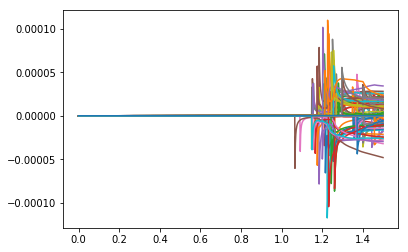

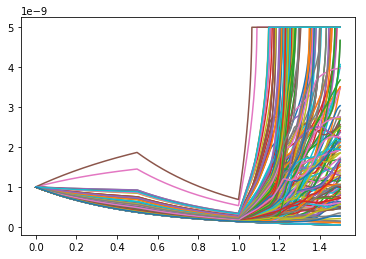

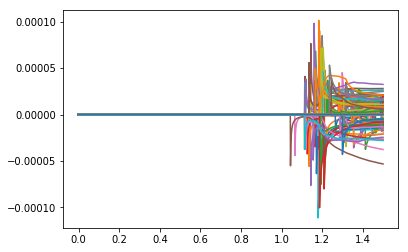

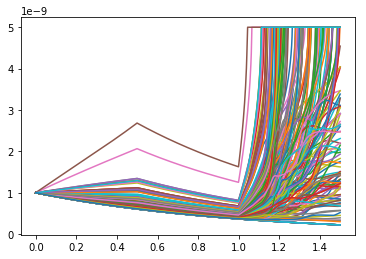

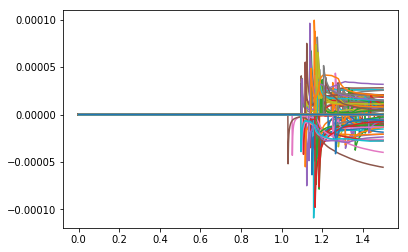

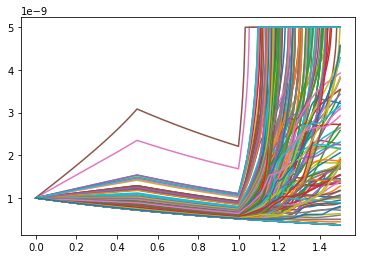

In [66]:
import matplotlib.pyplot as pyplot
for state in range(3):
    for i in range(len(data[state][2])):
        pyplot.plot(data[state][0], data[state][2][i])
    pyplot.show()
    for i in range(len(data[state][2])):
        pyplot.plot(data[state][0], data[state][3][i])
    pyplot.show()